# Model Building Notebook 

### Steps to be followed after data preprocessing:
1. Data splitting into training/validation/holdout paritions 
2. Selection of models to be tested under cross validation 
3. 10-Fold CV on training partition to check for in-sample accuracy 
4. Fit the models on training set and evaluate performance using validation set (still in-sample data)
5. Re-assess models after feature elimination / dimension reduction using 10-Fold CV 
6. Repeat step 4 
7. Optimize the learning models using evolutionary GA search (GridSearch removed due to extremely high complexity time)
8. Re-assess the models after fitting them
9. Generate performance metrics (Confusion matrix, ROC curve, feature importance bar-plot, train-test accuracy graph)
10. Fit these models in an ensemble stack and then assess their combined predicitive metrics
11. Assess the ensemble stack against RNN

In [101]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sklearn as sk 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
StandardScaler?

## Class to hold all the instance methods for model building and data scaling

In [61]:
class ModelBuilder:
    pass #No class attribute needed

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train #Instance attributes 
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test 

    #Data scaling using MinMax
    def data_scaler(self, Xtrain_cols, Xtest_cols, needs_training_as_scaled=True):
        scaler = MinMaxScaler(feature_range=(0,1)).fit(self.X_train)
        if needs_training_as_scaled is True:
            X_train_scaled = scaler.transform(self.X_train)
            scaled_df_train = pd.DataFrame(X_train_scaled, columns=Xtrain_cols)
            return scaled_df_train
        elif needs_training_as_scaled is not True:
            X_test_scaled = scaler.transform(self.X_test)
            scaled_df_test = pd.DataFrame(X_test_scaled, columns=Xtest_cols)
            return scaled_df_test
    
    #Data standardization using StandardScaler
    def data_standardizer(self, Xtrain_cols, Xtest_cols, needs_training_as_scaled=True):
        standardizer = StandardScaler().fit(self.X_train)
        if needs_training_as_scaled is True:
            X_train_standard = standardizer.transform(self.X_train)
            standard_df_train = pd.DataFrame(X_train_standard, columns=Xtrain_cols)
            return standard_df_train
        elif needs_training_as_scaled is not True:
            X_test_standard = standardizer.transform(self.X_test)
            standard_df_test = pd.DataFrame(X_test_standard, columns=Xtrain_cols)
            return X_test_standard

    #10-fold cross validation on the scaled data 
    def cross_validator(self, model, X_train_scaled, n_folds=10, has_scaled_data=True):
        if has_scaled_data != True:
            raise ValueError('Data not scaled. Scale data first')
        else:
            model_cv = cross_val_score(model, X_train_scaled, self.y_train, cv=n_folds, scoring='accuracy')
            print('10 Fold CV scores: ', model_cv)
            print('Mean 10-fold CV score: ', np.mean(model_cv))

    
    #Model fitter after data scaling on learning algorithms  
    def model_fitter(self, model, X_train_scaled, X_test_scaled, is_scaled=True):
        if is_scaled != True:
            raise ValueError("Data not scaled.")
        
        if is_scaled == True:
            model.fit(X_train_scaled, self.y_train)
            predictions = model.predict(X_test_scaled, self.y_test)
            metric = accuracy_score(self.y_test, predictions)
            print('Classification score: ', metric)

### Importing the dataset 

In [102]:
df = pd.read_csv('/home/sauraj/Desktop/Notebooks/Research/finalspy.csv')
df.index = pd.to_datetime(df['Date'])

In [103]:
df = df.drop(['Date'], axis=1)

In [104]:
#Dropping the first row with NaN values in it
df = df.drop(df.index[0])

In [7]:
df.head(5)

,High,Low,Open,Close,Volume,Adj Close,5-DayEMA,20-DayEMA,Real Lower Band,Real Middle Band,Real Upper Band,MACD,MACD_Hist,MACD_Signal,SlowD,SlowK,CCI,OBV,EMA_Reversal,EMA_Trend,StoReversal,MACDTrend,OBVTrend,CCITrend,Returns,MarketTrend
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-02-23,104.250000,103.343697,104.250000,104.062500,3227800,71.191544,103.899979,103.869506,96.2644,100.8570,105.4496,2.0341,0.1147,1.9194,87.2955,88.3007,114.5056,39995300,0.030473,Reversal,NoReversal,Up,Up,Reversal,-0.003904,Reversal
1998-02-24,104.093697,102.937500,103.906197,103.250000,3386800,70.635689,103.592094,103.642027,97.1356,101.2258,105.3159,1.9688,0.0395,1.9293,85.9809,78.9543,93.2333,36608500,-0.049933,Reversal,NoReversal,Reversal,Down,NoReversal,0.007869,Reversal
1998-02-25,104.875000,103.625000,103.750000,104.531197,3481800,71.512207,103.982183,103.898717,97.8045,101.6101,105.4158,1.9974,0.0545,1.9429,80.9184,75.5002,124.9737,40090300,0.083466,Reversal,NoReversal,Reversal,Up,Reversal,-0.012257,Reversal
1998-02-26,105.218697,104.187500,104.437500,105.125000,3187600,71.918427,104.420895,104.195344,98.3230,101.9805,105.6379,2.0444,0.0812,1.9632,77.2805,77.3869,140.6155,43277900,0.225551,Up,NoReversal,Reversal,Up,Reversal,-0.005649,Reversal
1998-02-27,105.531197,104.531197,104.968697,105.125000,3442900,71.918427,104.678184,104.391459,98.8459,102.3242,105.8025,2.0580,0.0758,1.9822,80.6615,89.0974,140.6006,43277900,0.286725,Up,NoReversal,Reversal,Up,Reversal,0.000000,Reversal


### Data preprocessing for categorical variables 

In [105]:
#The predictor column needs to have the right labelling 
for i in range(len(df)):
    if df['MarketTrend'][i] == 'Up':
        df['MarketTrend'][i] = 'Bullish'
    if df['MarketTrend'][i] == 'Down':
        df['MarketTrend'][i] = 'Bearish'

/home/sauraj/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/sauraj/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
df['Trend'] = ''
for i in range(len(df)):
    if df['Close'][i] > df['Close'][i-1]:
        df['Trend'][i] = 'Up'
    if df['Close'][i] < df['Close'][i-1]:
        df['Trend'][i] = 'Down'
        

/home/sauraj/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sauraj/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Creating dummy variables for categorical features 

In [106]:
obj_cols = df.select_dtypes(include=['object']).columns.values

In [107]:
obj_cols

array(['EMA_Trend', 'StoReversal', 'MACDTrend', 'OBVTrend', 'CCITrend',
       'MarketTrend'], dtype=object)

In [108]:
df = pd.get_dummies(df, columns=['EMA_Trend', 'StoReversal','MACDTrend','OBVTrend','CCITrend'])

In [111]:
df.head(30)
#df = df.drop(['MarketTrend'],axis=1)

,High,Low,Open,Close,Volume,Adj Close,5-DayEMA,20-DayEMA,Real Lower Band,Real Middle Band,Real Upper Band,MACD,MACD_Hist,MACD_Signal,SlowD,SlowK,CCI,OBV,EMA_Reversal,Returns,MarketTrend,EMA_Trend_Down,EMA_Trend_Reversal,EMA_Trend_Up,StoReversal_NoReversal,StoReversal_Reversal,MACDTrend_Down,MACDTrend_Reversal,MACDTrend_Up,OBVTrend_Down,OBVTrend_Up,CCITrend_NoReversal,CCITrend_Reversal,Trend
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-02-23,104.250000,103.343697,104.250000,104.062500,3227800,71.191544,103.899979,103.869506,96.2644,100.8570,105.4496,2.0341,0.1147,1.9194,87.2955,88.3007,114.5056,39995300,0.030473,-0.003904,Reversal,0,1,0,1,0,0,0,1,0,1,0,1,Reversal
1998-02-24,104.093697,102.937500,103.906197,103.250000,3386800,70.635689,103.592094,103.642027,97.1356,101.2258,105.3159,1.9688,0.0395,1.9293,85.9809,78.9543,93.2333,36608500,-0.049933,0.007869,Reversal,0,1,0,1,0,0,1,0,1,0,1,0,Reversal
1998-02-25,104.875000,103.625000,103.750000,104.531197,3481800,71.512207,103.982183,103.898717,97.8045,101.6101,105.4158,1.9974,0.0545,1.9429,80.9184,75.5002,124.9737,40090300,0.083466,-0.012257,Reversal,0,1,0,1,0,0,1,0,0,1,0,1,Reversal
1998-02-26,105.218697,104.187500,104.437500,105.125000,3187600,71.918427,104.420895,104.195344,98.3230,101.9805,105.6379,2.0444,0.0812,1.9632,77.2805,77.3869,140.6155,43277900,0.225551,-0.005649,Reversal,0,0,1,1,0,0,1,0,0,1,0,1,Reversal
1998-02-27,105.531197,104.531197,104.968697,105.125000,3442900,71.918427,104.678184,104.391459,98.8459,102.3242,105.8025,2.0580,0.0758,1.9822,80.6615,89.0974,140.6006,43277900,0.286725,0.000000,Reversal,0,0,1,1,0,0,1,0,0,1,0,1,Reversal
1998-03-02,105.750000,104.625000,105.250000,104.906197,4252300,71.768776,104.758913,104.488783,99.5269,102.6539,105.7809,2.0277,0.0364,1.9913,83.3883,83.6808,130.1262,39025600,0.270130,0.002086,Reversal,0,0,1,1,0,0,1,0,1,0,0,1,Reversal
1998-03-03,105.625000,104.531197,104.531197,105.500000,3349200,72.174965,105.015972,104.663577,99.8315,102.9320,106.0325,2.0282,0.0295,1.9987,84.5452,80.8575,122.7682,42374800,0.352395,-0.005628,Reversal,0,0,1,1,0,0,1,0,0,1,0,1,Reversal
1998-03-04,105.406197,104.437500,105.093697,104.812500,4404100,71.704651,104.946337,104.687465,100.1146,103.1383,106.1620,1.9507,-0.0384,1.9891,76.8720,66.0778,97.0422,37970700,0.258872,0.006559,Reversal,0,0,1,1,0,0,1,0,1,0,1,0,Reversal
1998-03-05,104.437500,103.156197,103.500000,103.843697,7268000,71.041862,104.572304,104.560401,100.5081,103.3023,106.0965,1.7904,-0.1589,1.9493,66.1719,51.5803,34.4516,30702700,0.011903,0.009329,Reversal,0,1,0,1,0,1,0,0,1,0,1,0,Reversal


In [113]:
df['MarketTrend'] = df['MarketTrend'].astype('category')
df['MarketTrend'] = df['MarketTrend'].cat.codes

#for i in range(len(df)):
    #if df['Trend'][i] == 1:
        #df['Trend'][i] = 0
    #if df['Trend'][i] == 2:
       # df['Trend'][i] = 1

In [118]:
df.head(10)

,High,Low,Open,Close,Volume,Adj Close,5-DayEMA,20-DayEMA,Real Lower Band,Real Middle Band,Real Upper Band,MACD,MACD_Hist,MACD_Signal,SlowD,SlowK,CCI,OBV,EMA_Reversal,Returns,MarketTrend,EMA_Trend_Down,EMA_Trend_Reversal,EMA_Trend_Up,StoReversal_NoReversal,StoReversal_Reversal,MACDTrend_Down,MACDTrend_Reversal,MACDTrend_Up,OBVTrend_Down,OBVTrend_Up,CCITrend_NoReversal,CCITrend_Reversal
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-02-23,104.250000,103.343697,104.250000,104.062500,3227800,71.191544,103.899979,103.869506,96.2644,100.8570,105.4496,2.0341,0.1147,1.9194,87.2955,88.3007,114.5056,39995300,0.030473,-0.003904,2,0,1,0,1,0,0,0,1,0,1,0,1
1998-02-24,104.093697,102.937500,103.906197,103.250000,3386800,70.635689,103.592094,103.642027,97.1356,101.2258,105.3159,1.9688,0.0395,1.9293,85.9809,78.9543,93.2333,36608500,-0.049933,0.007869,2,0,1,0,1,0,0,1,0,1,0,1,0
1998-02-25,104.875000,103.625000,103.750000,104.531197,3481800,71.512207,103.982183,103.898717,97.8045,101.6101,105.4158,1.9974,0.0545,1.9429,80.9184,75.5002,124.9737,40090300,0.083466,-0.012257,2,0,1,0,1,0,0,1,0,0,1,0,1
1998-02-26,105.218697,104.187500,104.437500,105.125000,3187600,71.918427,104.420895,104.195344,98.3230,101.9805,105.6379,2.0444,0.0812,1.9632,77.2805,77.3869,140.6155,43277900,0.225551,-0.005649,2,0,0,1,1,0,0,1,0,0,1,0,1
1998-02-27,105.531197,104.531197,104.968697,105.125000,3442900,71.918427,104.678184,104.391459,98.8459,102.3242,105.8025,2.0580,0.0758,1.9822,80.6615,89.0974,140.6006,43277900,0.286725,0.000000,2,0,0,1,1,0,0,1,0,0,1,0,1
1998-03-02,105.750000,104.625000,105.250000,104.906197,4252300,71.768776,104.758913,104.488783,99.5269,102.6539,105.7809,2.0277,0.0364,1.9913,83.3883,83.6808,130.1262,39025600,0.270130,0.002086,2,0,0,1,1,0,0,1,0,1,0,0,1
1998-03-03,105.625000,104.531197,104.531197,105.500000,3349200,72.174965,105.015972,104.663577,99.8315,102.9320,106.0325,2.0282,0.0295,1.9987,84.5452,80.8575,122.7682,42374800,0.352395,-0.005628,2,0,0,1,1,0,0,1,0,0,1,0,1
1998-03-04,105.406197,104.437500,105.093697,104.812500,4404100,71.704651,104.946337,104.687465,100.1146,103.1383,106.1620,1.9507,-0.0384,1.9891,76.8720,66.0778,97.0422,37970700,0.258872,0.006559,2,0,0,1,1,0,0,1,0,1,0,1,0
1998-03-05,104.437500,103.156197,103.500000,103.843697,7268000,71.041862,104.572304,104.560401,100.5081,103.3023,106.0965,1.7904,-0.1589,1.9493,66.1719,51.5803,34.4516,30702700,0.011903,0.009329,2,0,1,0,1,0,1,0,0,1,0,1,0


In [112]:
#Check for datatypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5245 entries, 1998-02-23 to 2018-12-24
Data columns (total 34 columns):
High                      5245 non-null float64
Low                       5245 non-null float64
Open                      5245 non-null float64
Close                     5245 non-null float64
Volume                    5245 non-null int64
Adj Close                 5245 non-null float64
5-DayEMA                  5245 non-null float64
20-DayEMA                 5245 non-null float64
Real Lower Band           5245 non-null float64
Real Middle Band          5245 non-null float64
Real Upper Band           5245 non-null float64
MACD                      5245 non-null float64
MACD_Hist                 5245 non-null float64
MACD_Signal               5245 non-null float64
SlowD                     5245 non-null float64
SlowK                     5245 non-null float64
CCI                       5245 non-null float64
OBV                       5245 non-null int64
EMA_Reversal   

## Model Building

* We need to partition 80% of the dataset for **Training** and 20% for **Out of sample validation**. The **OOSV** set will only be used for **FINAL TESTING**

* The **Training** partition will be further split into **X** and **y** for training and validating the learning models

In [119]:
print("Training set partition size: ", len(df)*0.8)
print("Out of sample validation set partition size: ", len(df)*0.2)

Training set partition size:  4196.0
Out of sample validation set partition size:  1049.0


In [120]:
#Train and holdout partitions
train = df[0:4196]
holdout = df[4196:]

In [121]:
df2 = df[2733:]
print("Training set partition size: ", len(df2)*0.8)
print("Out of sample validation set partition size: ", len(df2)*0.2)

Training set partition size:  2009.6000000000001
Out of sample validation set partition size:  502.40000000000003


In [122]:
#Train and holdout partitions (after financial crisis)
train2 = df2[:2010]
holdout2 = df2[2010:]

### Next, the "train" partition is taken and is split into X and y

In [123]:
X = train.drop(['MarketTrend'],axis=1)
y = train['MarketTrend']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=46)

In [125]:
Xtrain_cols = X_train.columns
Xtest_cols = X_test.columns

## Feature Selection 


##### Strategy 1
* Select important features using decision tree pruning 
* Use those features to test for cross-validation 

##### Strategy 2 
* Run PCA on the dataset after normalizing it 
* Use the components to test for cross-validation

In [40]:
ExtraTreeClassifier?

#### Strategy 1: Decision Tree Pruning (Bias issue is persistent here)

In [126]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from yellowbrick.features import RFECV, FeatureImportances

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


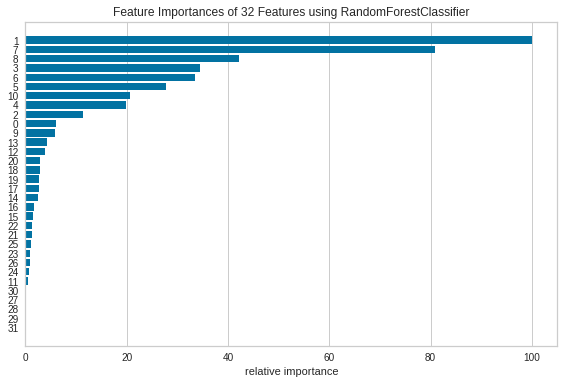

In [388]:
minSplitNum = int(len(X_train))
minLeafNum = int(len(X_train))



viz = FeatureImportances(RandomForestClassifier())
viz.fit(pca_Xtrain, y_train)
viz.poof()

### Scaling the dataset 

In [181]:
#Scaled dataset 
builder = ModelBuilder(X_train, X_test, y_train, y_test)
Xtrain_scaled = builder.data_scaler(Xtrain_cols, Xtest_cols, needs_training_as_scaled=True)
Xtest_scaled = builder.data_scaler(Xtrain_cols, Xtest_cols, needs_training_as_scaled=False)

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [182]:
#Standardized dataset
Xtrain_standard = builder.data_standardizer(Xtrain_cols, Xtest_cols, needs_training_as_scaled=True)
Xtest_standard = builder.data_standardizer(Xtrain_cols, Xtest_cols, needs_training_as_scaled=False)

/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sauraj/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sauraj/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [227]:
Xtrain_standard.head()

,High,Low,Open,Close,Volume,Adj Close,5-DayEMA,20-DayEMA,Real Lower Band,Real Middle Band,Real Upper Band,MACD,MACD_Hist,MACD_Signal,SlowD,SlowK,CCI,OBV,EMA_Reversal,Returns,EMA_Trend_Down,EMA_Trend_Reversal,EMA_Trend_Up,StoReversal_NoReversal,StoReversal_Reversal,MACDTrend_Down,MACDTrend_Reversal,MACDTrend_Up,OBVTrend_Down,OBVTrend_Up,CCITrend_NoReversal,CCITrend_Reversal
0,-0.898188,-0.842975,-0.847315,-0.857842,-0.812666,-1.305719,-0.868996,-0.875594,-1.041439,-1.039668,-1.020685,1.369637,0.276256,1.365046,1.330552,1.264587,0.934149,-0.689205,-0.012700,-0.289201,-0.815281,5.510398,-1.148600,0.248373,-0.248373,-0.814774,-0.537389,1.285677,-0.936460,0.952270,-1.092458,1.092458
1,-0.906869,-0.865442,-0.866343,-0.902904,-0.811270,-1.343442,-0.886129,-0.888369,-0.993673,-1.019051,-1.028183,1.324138,0.101040,1.372362,1.275668,0.905151,0.737327,-0.691216,-0.054948,0.576675,-0.815281,5.510398,-1.148600,0.248373,-0.248373,-0.814774,1.860851,-0.777801,1.067851,-1.050122,0.915367,-0.915367
2,-0.863476,-0.827416,-0.874988,-0.831847,-0.810437,-1.283957,-0.864421,-0.873953,-0.956998,-0.997568,-1.022581,1.344065,0.135990,1.382413,1.064311,0.772316,1.031005,-0.689148,0.015145,-0.903448,-0.815281,5.510398,-1.148600,0.248373,-0.248373,-0.814774,1.860851,-0.777801,-0.936460,0.952270,-1.092458,1.092458
3,-0.844387,-0.796305,-0.836938,-0.798914,-0.813018,-1.256389,-0.840006,-0.857295,-0.928569,-0.976862,-1.010126,1.376814,0.198201,1.397415,0.912431,0.844873,1.175731,-0.687256,0.089802,-0.417470,-0.815281,-0.181475,0.870625,0.248373,-0.248373,-0.814774,1.860851,-0.777801,-0.936460,0.952270,-1.092458,1.092458
4,-0.827031,-0.777295,-0.807538,-0.798914,-0.810778,-1.256389,-0.825688,-0.846281,-0.899899,-0.957648,-1.000895,1.386290,0.185619,1.411456,1.053586,1.295226,1.175593,-0.687256,0.121946,-0.002056,-0.815281,-0.181475,0.870625,0.248373,-0.248373,-0.814774,1.860851,-0.777801,-0.936460,0.952270,-1.092458,1.092458


In [229]:
Xtrain_scaled.head()

,High,Low,Open,Close,Volume,Adj Close,5-DayEMA,20-DayEMA,Real Lower Band,Real Middle Band,Real Upper Band,MACD,MACD_Hist,MACD_Signal,SlowD,SlowK,CCI,OBV,EMA_Reversal,Returns,EMA_Trend_Down,EMA_Trend_Reversal,EMA_Trend_Up,StoReversal_NoReversal,StoReversal_Reversal,MACDTrend_Down,MACDTrend_Reversal,MACDTrend_Up,OBVTrend_Down,OBVTrend_Up,CCITrend_NoReversal,CCITrend_Reversal
0,0.391339,0.410414,0.407957,0.406841,0.002060,0.228902,0.397462,0.369201,0.359991,0.334691,0.317280,0.876963,0.621083,0.910375,0.886167,0.894953,0.760477,0.321249,0.688682,0.520725,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.389553,0.405815,0.404093,0.397646,0.002243,0.220775,0.393887,0.366323,0.370177,0.339302,0.315554,0.871196,0.604822,0.911368,0.871943,0.798051,0.729363,0.320917,0.684682,0.570616,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.398480,0.413600,0.402338,0.412144,0.002352,0.233590,0.398416,0.369571,0.377999,0.344108,0.316844,0.873722,0.608066,0.912732,0.817168,0.762240,0.775788,0.321258,0.691319,0.485332,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.402407,0.419969,0.410064,0.418864,0.002014,0.239529,0.403510,0.373324,0.384061,0.348740,0.319712,0.877872,0.613839,0.914768,0.777806,0.781801,0.798666,0.321571,0.698388,0.513334,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.405978,0.423861,0.416034,0.418864,0.002307,0.239529,0.406497,0.375806,0.390175,0.353038,0.321837,0.879073,0.612672,0.916673,0.814388,0.903213,0.798644,0.321571,0.701432,0.537270,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## Principal Components Analysis

In [472]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10).fit(Xtrain_standard, y_train)
pca_Xtrain = pca.transform(Xtrain_standard)
pca_Xtest = pca.transform(Xtest_standard)
np.sum(pca.explained_variance_ratio_)

0.9461563514439943

In [452]:
from sklearn.decomposition import PCA
from yellowbrick.features.pca import PCADecomposition

colors = np.array(['r' if yi else 'b' for yi in y_train])

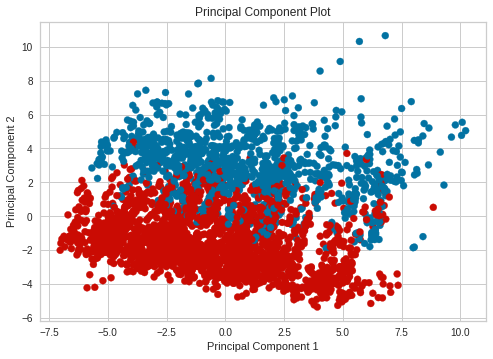

In [473]:
visualizer = PCADecomposition(color=colors, proj_dim=2)
visualizer.fit_transform(Xtrain_scaled, y_train)
visualizer.poof()

### Model Testing 

In [455]:
#Importing in models to use 
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score

knnc = KNeighborsClassifier()
knnr = KNeighborsRegressor()
rfr = RandomForestRegressor()
rfc = RandomForestClassifier()
svr = SVR(gamma='auto')
svc = SVC(gamma='auto')
logreg = LogisticRegression(solver='lbfgs')

In [474]:
svr_cv = cross_val_score(svc, pca_Xtrain, y_train, cv=10, scoring='accuracy')

In [475]:
abs(svr_cv.mean())

0.9913459381875906

In [476]:
rfc.fit(pca_Xtrain, y_train)
rfc_predictions = rfc.predict(pca_Xtest)

In [477]:
svc.fit(pca_Xtrain, y_train)
svc_predictions = svc.predict(pca_Xtest)

In [478]:
knnc.fit(pca_Xtrain, y_train)
knnc_predictions = knnc.predict(pca_Xtest)

In [479]:
accuracy_score(y_test, rfc_predictions)

0.9130952380952381

In [440]:
rfc_predictions

array([2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1,
       1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1,
       1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,

In [480]:
accuracy_score(y_test, svc_predictions)

0.7023809523809523

In [481]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, rfc_predictions))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       211
           1       0.99      0.87      0.93       426
           2       1.00      0.91      0.95       203

   micro avg       0.91      0.91      0.91       840
   macro avg       0.91      0.93      0.91       840
weighted avg       0.93      0.91      0.92       840



/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


/home/sauraj/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LearningCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc206274550>,
       cv=10, exploit_incremental_learning=False, groups=None, model=None,
       n_jobs=1, pre_dispatch='all', random_state=None, scoring='accuracy',
       shuffle=False,
       train_sizes=array([0.3    , 0.37778, 0.45556, 0.53333, 0.61111, 0.68889, 0.76667,
       0.84444, 0.92222, 1.     ]))

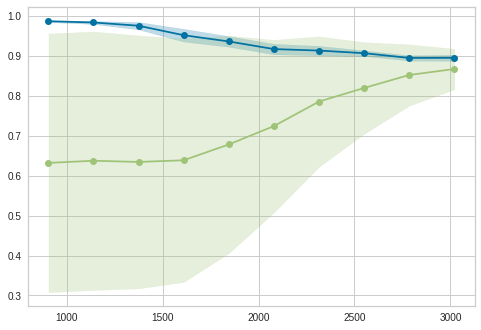

In [463]:
from yellowbrick.model_selection import LearningCurve

viz = LearningCurve(logreg, cv=10, train_sizes=np.linspace(0.3, 1.0, 10), scoring='accuracy')
viz.fit(pca_Xtrain, y_train)

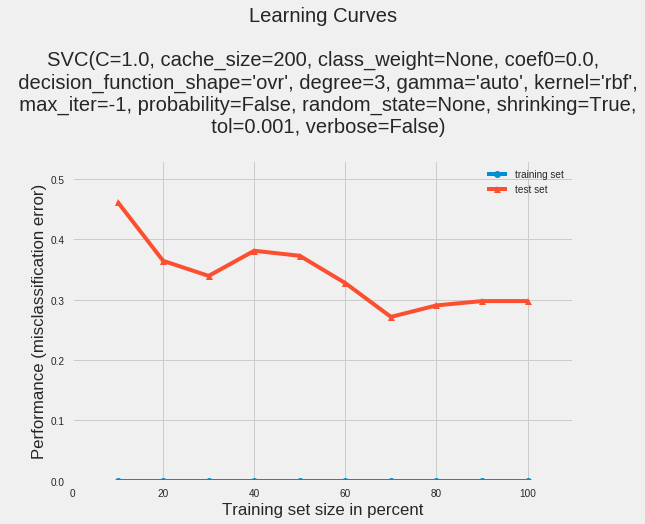

In [482]:
from mlxtend.plotting import plot_learning_curves

plot_learning_curves(pca_Xtrain, y_train, pca_Xtest, y_test, svc)
plt.show()

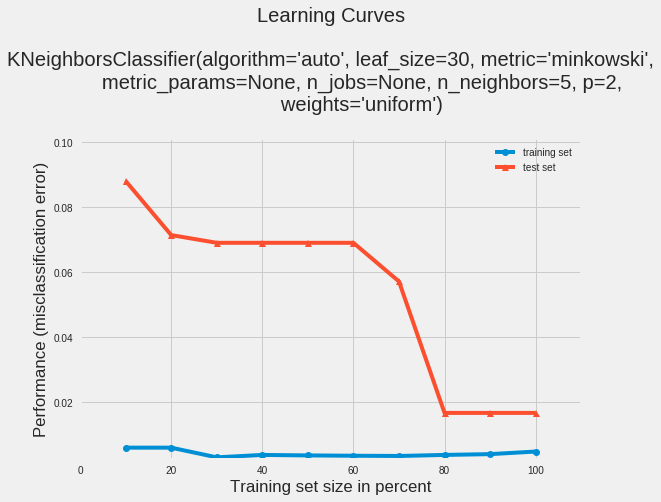

In [483]:
plot_learning_curves(pca_Xtrain, y_train, pca_Xtest, y_test, knnc)
plt.show()

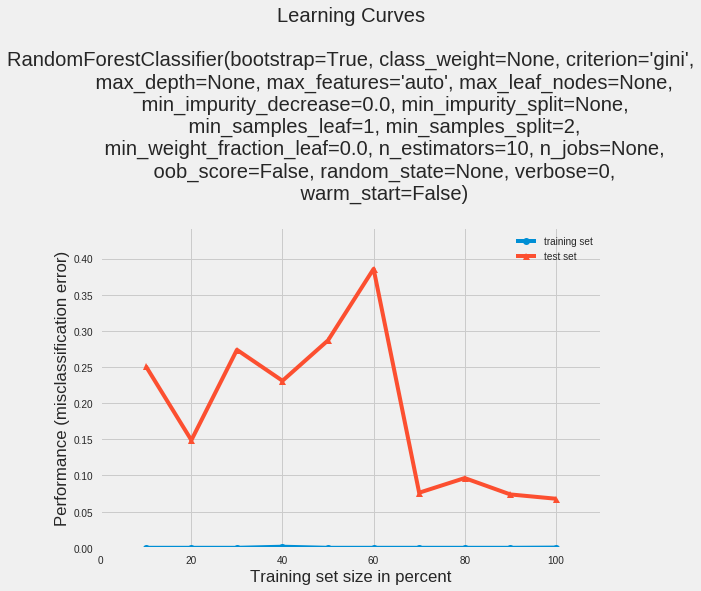

In [484]:
plot_learning_curves(pca_Xtrain, y_train, pca_Xtest, y_test, rfc)
plt.show()

In [283]:
svr_predictions2 = abs(svr_predictions)

In [492]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(svc, forward=True,floating=False,verbose=2,scoring='accuracy',cv=0)
sfs1 = sfs1.fit(Xtrain_scaled, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   15.6s finished

[2019-01-25 15:45:14] Features: 1/1 -- score: 0.7666865315852205

### Hypothesis testing (prototyping to see if it really works on not)

In [403]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p  = paired_ttest_5x2cv(estimator1=svc,
                          estimator2=knnc,
                          X=pca_Xtrain, y=y_train,
                          random_seed=1)

#### Under the prototype, support vector recognition and knn regressor as two different models are statistically different from each other

In [404]:
print('t statistic: %.3f' %t)
print('p value: %.3f' %p)

t statistic: 6.922
p value: 0.001


In [642]:
from keras import Sequential 
from keras.layers import Dense, LSTM

model = Sequential()
model.add(Dense(12, input_dim=Xtrain_scaled.shape[1], activation='softmax'))
model.add(Dense(16, activation='softmax'))
model.add(Dense(10, activation='softmax'))
model.add(Dense(4, activation='softmax'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
history = model.fit(Xtrain_scaled, Y, epochs=200, validation_data=(Xtest_scaled, Y_test))

Train on 3356 samples, validate on 840 samples
Epoch 1/200
3356/3356 [==============================] - 4s 1ms/step - loss: 1.0888 - acc: 0.4044 - val_loss: 1.0528 - val_acc: 0.5071
Epoch 2/200
3356/3356 [==============================] - 1s 218us/step - loss: 1.0792 - acc: 0.4044 - val_loss: 1.0555 - val_acc: 0.5071
Epoch 3/200
3356/3356 [==============================] - 1s 175us/step - loss: 1.0765 - acc: 0.4044 - val_loss: 1.0557 - val_acc: 0.5071
Epoch 4/200
3356/3356 [==============================] - 0s 132us/step - loss: 1.0734 - acc: 0.4044 - val_loss: 1.0537 - val_acc: 0.5071
Epoch 5/200
3356/3356 [==============================] - 0s 120us/step - loss: 1.0689 - acc: 0.4044 - val_loss: 1.0495 - val_acc: 0.5071
Epoch 6/200
3356/3356 [==============================] - 0s 115us/step - loss: 1.0626 - acc: 0.4044 - val_loss: 1.0438 - val_acc: 0.5071
Epoch 7/200
3356/3356 [==============================] - 0s 147us/step - loss: 1.0538 - acc: 0.4044 - val_loss: 1.0352 - val_acc: 0.5

Epoch 60/200
3356/3356 [==============================] - 1s 207us/step - loss: 0.5098 - acc: 0.7530 - val_loss: 0.5471 - val_acc: 0.7583
Epoch 61/200
3356/3356 [==============================] - 1s 261us/step - loss: 0.5084 - acc: 0.7530 - val_loss: 0.5459 - val_acc: 0.7583
Epoch 62/200
3356/3356 [==============================] - 0s 128us/step - loss: 0.5072 - acc: 0.7530 - val_loss: 0.5447 - val_acc: 0.7583
Epoch 63/200
3356/3356 [==============================] - 0s 130us/step - loss: 0.5059 - acc: 0.7530 - val_loss: 0.5436 - val_acc: 0.7583
Epoch 64/200
3356/3356 [==============================] - 0s 136us/step - loss: 0.5048 - acc: 0.7530 - val_loss: 0.5426 - val_acc: 0.7583
Epoch 65/200
3356/3356 [==============================] - 1s 174us/step - loss: 0.5036 - acc: 0.7530 - val_loss: 0.5415 - val_acc: 0.7583
Epoch 66/200
3356/3356 [==============================] - 1s 232us/step - loss: 0.5025 - acc: 0.7530 - val_loss: 0.5405 - val_acc: 0.7583
Epoch 67/200
3356/3356 [==========

3356/3356 [==============================] - 0s 122us/step - loss: 0.4604 - acc: 0.7530 - val_loss: 0.5021 - val_acc: 0.7583
Epoch 179/200
3356/3356 [==============================] - 0s 98us/step - loss: 0.4602 - acc: 0.7530 - val_loss: 0.5020 - val_acc: 0.7583
Epoch 180/200
3356/3356 [==============================] - 0s 99us/step - loss: 0.4601 - acc: 0.7530 - val_loss: 0.5019 - val_acc: 0.7583
Epoch 181/200
3356/3356 [==============================] - 0s 124us/step - loss: 0.4599 - acc: 0.7530 - val_loss: 0.5018 - val_acc: 0.7583
Epoch 182/200
3356/3356 [==============================] - 0s 144us/step - loss: 0.4598 - acc: 0.7530 - val_loss: 0.5017 - val_acc: 0.7583
Epoch 183/200
3356/3356 [==============================] - 0s 110us/step - loss: 0.4597 - acc: 0.7530 - val_loss: 0.5015 - val_acc: 0.7583
Epoch 184/200
3356/3356 [==============================] - 1s 169us/step - loss: 0.4595 - acc: 0.7530 - val_loss: 0.5014 - val_acc: 0.7583
Epoch 185/200
3356/3356 [==================

In [564]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Y = encoder.fit_transform(y_train)
Y_test = encoder.fit_transform(y_test)

In [631]:
nn_predictions3 = encoder.inverse_transform(nn_predictions)

In [630]:
nn_predictions = model.predict(Xtest_scaled)

In [632]:
nn_predictions2 = abs(nn_predictions.round())

In [ ]:
Y

In [633]:
accuracy_score(y_test, nn_predictions3)

0.9261904761904762

Text(0.5, 0, 'Epochs')

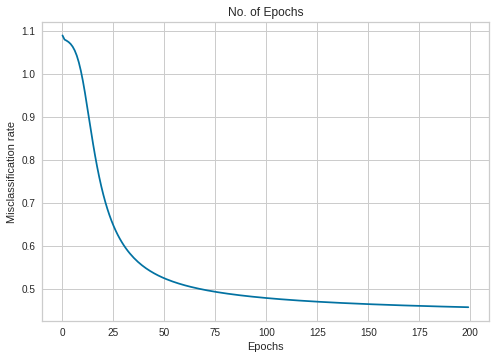

In [643]:
plt.plot(history.history['loss'])
plt.title('No. of Epochs')
plt.ylabel('Misclassification rate')
plt.xlabel('Epochs')